In [47]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
sns.set(font=['sans-serif'])
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
from tqdm import tqdm
import zhplot
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore')
from collections import defaultdict

In [48]:
def count_mdd(df_profit,window):
    Roll_Max = df_profit.rolling(window, min_periods=1).max()
    # Daily_Drawdown = df_profit/Roll_Max - 1
    Daily_Drawdown = df_profit-Roll_Max
    return Daily_Drawdown
def event_study(df:pd.DataFrame,Xname:str,Yname:str,market_dates:list,event_date:str,backward:int,forward:int):
    '''
    df(DataFrame): which contain market return (X) & stock return (Y)
    Xname(str): name of the columns which contain market return (X)
    Yname(str): name of the columns which contain stock return (Y)
    market_dates(list): dates that the market open
    event_date(str): event date
    backwart(int): days to look backward
    forwart(int) : days to look forward
    return abR : abnormal Return
    '''
    abR = np.nan*(backward+forward+1)
    event = market_dates.index(pd.to_datetime(event_date))
    if event-forward>=0 and event+forward<len(market_dates):
        start = market_dates[event-backward]
        end = market_dates[event+forward]
        window = df.loc[start:end].sort_index(ascending=True).dropna()
        if len(window)==(backward+forward+1):
            X = window[Xname]
            Y = window[Yname]
            X = sm.add_constant(X)
            model = sm.OLS(Y,X).fit()
            expect = model.predict(X)
            abR= Y-expect
            return abR.to_list()
    else:
        pass

In [49]:
df_index = pd.read_csv('Data/TWindex.csv',index_col=0).sort_index(ascending=True)
df_index.index = pd.to_datetime(df_index.index)
Update_index = pd.read_excel("Data/daily_blackK_Update.xlsx",sheet_name='加權指數',header=None,usecols="B:F").loc[5:]
Update_index.columns = ['日期','開盤價', '最高價', '最低價', '收盤價']
Update_index['日期'] = pd.to_datetime(Update_index['日期'])
Update_index = Update_index.set_index('日期')
for c in Update_index.columns:
    Update_index[c]=Update_index[c].astype(float)
if Update_index.index[-1]!= df_index.index[-1]:
    df_index = pd.concat([df_index,Update_index],axis=0)
df_index.to_csv('Data/TWindex.csv')
df_index['指數報酬率'] = df_index['收盤價'].pct_change(5)
df_index['指數變化率'] = df_index['收盤價'].pct_change(1)
df_index['SMA'] = df_index['收盤價'].rolling(90,min_periods=1).mean()
df_index.tail(3)

,開盤價,最高價,最低價,收盤價,指數報酬率,指數變化率,SMA
日期,,,,,,,
2025-07-04,22756.55,22842.75,22500.97,22547.50,-0.001443,-0.007285,21437.609667
2025-07-07,22550.14,22550.50,22294.11,22428.72,0.007760,-0.005268,21424.980889
2025-07-08,22375.65,22375.65,22190.46,22362.27,-0.008489,-0.002963,21414.720333


In [50]:
data = pd.read_csv('Data/stock_daily_beta.csv',index_col=0).sort_index(ascending=True)
data.index = pd.to_datetime(data.index)
data = data[data.index.isna()==False]
data.tail(3)

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2025-07-07,2440.0,太空梭,12.40,12.55,12.35,12.55,-0.25,-1.95,1.56,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-07,2399.0,映泰,18.05,18.05,17.50,17.50,-0.40,-2.23,3.07,658.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-07,9958.0,世紀鋼,221.00,222.50,214.50,216.50,-4.00,-1.81,3.63,10749.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
Update_data = pd.read_excel("Data/daily_blackK_Update.xlsx",sheet_name='上市日資料',header=None,index_col=False).loc[5:]
Update_data.columns = ['股票代號', '股票名稱', '日期','開盤價', '最高價', '最低價', '收盤價', '漲跌', '漲幅(%)', '振幅(%)',
       '成交量', '成交筆數', '成交金額(千)', '均張', '成交量變動(%)', '均張變動(%)', '股本(百萬)',
       '總市值(億)', '市值比重(%)', '本益比', '股價淨值比', '本益比(近四季)', '週轉率(%)', '成交值比重(%)',
       '漲跌停', '均價', '成交量(股)']
Update_data['日期'] = pd.to_datetime(Update_data['日期'])
for c in Update_data.columns:
       try:
              Update_data[c] = Update_data[c].replace('- -',np.nan).astype(float)
       except:
              pass
Update_data = Update_data.set_index('日期')
if data.index[-1]!=Update_data.index[-1]:
       print('Combine')
       data = pd.concat([data,Update_data],axis=0)
data

Combine


,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,9945.0,潤泰新,43.05,43.05,41.65,41.85,-1.35,-3.13,3.24,10638.0,...,NaN,NaN,42.05,41.15,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4904.0,遠傳,61.70,61.90,61.10,61.30,0.00,0.00,1.31,3870.0,...,NaN,NaN,61.40,60.80,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4766.0,南寶,128.00,128.00,126.00,126.50,-0.50,-0.39,1.57,88.0,...,NaN,NaN,127.00,126.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4763.0,材料-KY,127.50,127.50,126.00,127.50,0.00,0.00,1.18,138.0,...,NaN,NaN,127.50,126.50,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,6409.0,旭隼,1050.00,1055.00,1000.00,1010.00,-25.00,-2.42,5.31,226.0,...,NaN,NaN,1030.00,1025.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,9944.0,新麗,17.00,17.00,16.90,16.90,-0.20,-1.17,0.58,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9945.0,潤泰新,31.90,31.90,30.80,31.35,-0.60,-1.88,3.44,25632.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9946.0,三發地產,20.15,20.15,19.80,20.05,0.00,0.00,1.75,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
data['指數報酬率'] = df_index['指數報酬率']
data['指數變化率'] = df_index['指數變化率']
data['指數開盤價'] = df_index['開盤價']
data['指數收盤價'] = df_index['收盤價']
data['SMA'] = df_index['SMA']
data['本益比'] = data['本益比'].replace('- -',np.nan).astype(float)
data['均張變動(%)'] = data['均張變動(%)'].replace('- -',np.nan).astype(float)
data['股價淨值比'] = data['股價淨值比'].replace('- -',np.nan).astype(float)
data['個股報酬率'] = data.groupby('股票代號')['收盤價'].pct_change(5)
data['個股變化率'] = data.groupby('股票代號')['收盤價'].pct_change(1)
data['調整報酬率'] = data['個股報酬率'] - data['指數報酬率']
data['調整變化率'] = data['個股變化率'] - data['指數變化率']
# data['Beta'] = np.where(data['Beta'].isna()==True,data['指數Beta'],data['Beta'])
data

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,9945.0,潤泰新,43.05,43.05,41.65,41.85,-1.35,-3.13,3.24,10638.0,...,NaN,NaN,42.05,41.15,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4904.0,遠傳,61.70,61.90,61.10,61.30,0.00,0.00,1.31,3870.0,...,NaN,NaN,61.40,60.80,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4766.0,南寶,128.00,128.00,126.00,126.50,-0.50,-0.39,1.57,88.0,...,NaN,NaN,127.00,126.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4763.0,材料-KY,127.50,127.50,126.00,127.50,0.00,0.00,1.18,138.0,...,NaN,NaN,127.50,126.50,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,6409.0,旭隼,1050.00,1055.00,1000.00,1010.00,-25.00,-2.42,5.31,226.0,...,NaN,NaN,1030.00,1025.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,9944.0,新麗,17.00,17.00,16.90,16.90,-0.20,-1.17,0.58,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9945.0,潤泰新,31.90,31.90,30.80,31.35,-0.60,-1.88,3.44,25632.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9946.0,三發地產,20.15,20.15,19.80,20.05,0.00,0.00,1.75,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
marketdates = data.sort_index(ascending=True).groupby(data.index).first().index.to_list()
for d in tqdm(marketdates[len(marketdates)-1:]):
    end_date = d
    dd = marketdates.index(d)
    start_date = marketdates[dd-19]
    print(start_date,end_date)
    stock_pool = data.loc[d]['股票代號'].to_list()
    for stock in stock_pool:
        window = data.loc[(data['股票代號']==stock)&(data.index>=start_date)&(data.index<=end_date)][['指數變化率','個股變化率']].dropna()
        if len(window)>=20:
            Y = window['指數變化率']
            X = window['個股變化率']
            X = sm.add_constant(X)
            model = sm.OLS(Y,X).fit()
            b = model.params['個股變化率']
            data.loc[(data['股票代號']==stock)&(data.index==end_date),'Beta'] = b
data.to_csv('Data/stock_daily_beta.csv')
data

  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-11 00:00:00 2025-07-08 00:00:00


100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,9945.0,潤泰新,43.05,43.05,41.65,41.85,-1.35,-3.13,3.24,10638.0,...,NaN,NaN,42.05,41.15,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4904.0,遠傳,61.70,61.90,61.10,61.30,0.00,0.00,1.31,3870.0,...,NaN,NaN,61.40,60.80,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4766.0,南寶,128.00,128.00,126.00,126.50,-0.50,-0.39,1.57,88.0,...,NaN,NaN,127.00,126.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4763.0,材料-KY,127.50,127.50,126.00,127.50,0.00,0.00,1.18,138.0,...,NaN,NaN,127.50,126.50,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,6409.0,旭隼,1050.00,1055.00,1000.00,1010.00,-25.00,-2.42,5.31,226.0,...,NaN,NaN,1030.00,1025.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,9944.0,新麗,17.00,17.00,16.90,16.90,-0.20,-1.17,0.58,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9945.0,潤泰新,31.90,31.90,30.80,31.35,-0.60,-1.88,3.44,25632.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9946.0,三發地產,20.15,20.15,19.80,20.05,0.00,0.00,1.75,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_future = pd.read_csv('Data/stockfuture_pid.csv')
clean_pids = []
for pid in data_future['標的代號']:
    if str(pid).isnumeric()==True:
        clean_pids.append(float(pid))
    else:
        clean_pids.append(str(pid))
data_future['標的代號'] = clean_pids
data_future

,代號,名稱,交易標的,標的代號
0,BRF,布蘭特原油期貨,布蘭特原油(Brent Crude Oil),nan
1,BTF,臺灣生技期貨,臺灣指數公司臺灣上市上櫃生技醫療指數,TWA5T
2,CAF,南亞期貨,南亞,1303.0
3,CBF,中鋼期貨,中鋼,2002.0
4,CCF,聯電期貨,聯電,2303.0
...,...,...,...,...
285,XAF,澳幣兌美元期貨,澳幣兌美元匯率,nan
286,XBF,英鎊兌美元期貨,英鎊兌美元匯率,nan
287,XEF,歐元兌美元期貨,歐元兌美元匯率,nan
288,XIF,非金電期貨,臺灣證券交易所未含金融電子股發行量加權股價指數,TWA06


In [55]:
data

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,9945.0,潤泰新,43.05,43.05,41.65,41.85,-1.35,-3.13,3.24,10638.0,...,NaN,NaN,42.05,41.15,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4904.0,遠傳,61.70,61.90,61.10,61.30,0.00,0.00,1.31,3870.0,...,NaN,NaN,61.40,60.80,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4766.0,南寶,128.00,128.00,126.00,126.50,-0.50,-0.39,1.57,88.0,...,NaN,NaN,127.00,126.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,4763.0,材料-KY,127.50,127.50,126.00,127.50,0.00,0.00,1.18,138.0,...,NaN,NaN,127.50,126.50,-17.585,-4.88,-4.88,6.25,564.65,1.0
2020-09-01,6409.0,旭隼,1050.00,1055.00,1000.00,1010.00,-25.00,-2.42,5.31,226.0,...,NaN,NaN,1030.00,1025.00,-17.585,-4.88,-4.88,6.25,564.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,9944.0,新麗,17.00,17.00,16.90,16.90,-0.20,-1.17,0.58,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9945.0,潤泰新,31.90,31.90,30.80,31.35,-0.60,-1.88,3.44,25632.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-08,9946.0,三發地產,20.15,20.15,19.80,20.05,0.00,0.00,1.75,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
data['週轉變化率'] = data.groupby('股票代號')['週轉率(%)'].pct_change()
data['週轉變化率_Q3'] = data.groupby('日期')['週轉變化率'].quantile(0.70)
data['change'] = data.groupby('日期')['股價淨值比'].quantile(0.50)
data['Beta_Q2'] = data.groupby('日期')['均張變動(%)'].quantile(0.50)
data['Daily'] = np.where(data['指數開盤價']>data['SMA'],1,-1)


df_stock = data[((data['收盤價']>30)&(data['指數開盤價']>data['SMA'])&(data['週轉率(%)']>2)&(data['股價淨值比']>data['change'])&(data['調整報酬率']<-0.05)&(data['Beta']>data['Beta_Q2']))|
                ((data['收盤價']>30)&(data['指數開盤價']<data['SMA'])&(data['週轉變化率']<data['週轉變化率_Q3'])&(data['週轉率(%)']>2)&(data['股價淨值比']>data['change'])&(data['調整報酬率']<-0.05)&(data['Beta']>-1))]
# df_stock = data[((data['開盤價']>50)&(data['指數開盤價']>data['SMA'])&(data['週轉率(%)']>2)&(data['股價淨值比']>data['change1'])&(data['調整報酬率']<-0.05)&(data['Beta']>data['Beta_Q2']))|
#                 ((data['開盤價']>50)&(data['指數開盤價']<data['SMA'])&(data['週轉變化率']<data['週轉變化率_Q3'])&(data['週轉率(%)']>2)&(data['股價淨值比']>data['change1'])&(data['調整報酬率']<-0.05)&(data['Beta']>data['Beta_Q1']))]
# df_stock = data[((data['指數開盤價']>data['SMA'])&(data['週轉率(%)']>2)&(data['週轉變化率']>data['週轉變化率_Q3'])&(data['股價淨值比']>data['change1'])&(data['調整報酬率']<-0.05)&(data['Beta']>data['Beta_Q2']))|((data['指數開盤價']<data['SMA'])&(data['週轉變化率']<data['週轉變化率_Q3'])&(data['週轉率(%)']>2)&(data['股價淨值比']>data['change1'])&(data['調整報酬率']<-0.05)&(data['Beta']>data['Beta_Q1']))]
df_stock

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-30,5269.0,祥碩,1415.00,1465.0,1400.00,1455.00,60.00,4.30,4.66,1419.0,...,1480.0,1390.00,1450.0,1435.0,-17.405,-5.26,-5.26,2.1375,553.5,1
2020-09-30,3661.0,世芯-KY,468.00,487.5,452.50,487.50,16.50,3.50,7.43,10205.0,...,480.0,462.00,486.0,473.0,-17.405,-5.26,-5.26,2.1375,553.5,1
2020-09-30,6531.0,愛普,325.00,329.0,316.50,329.00,7.50,2.33,3.89,2320.0,...,335.5,321.50,330.0,323.0,-17.405,-5.26,-5.26,2.1375,553.5,1
2020-09-30,8046.0,南電,116.50,119.0,114.00,118.00,2.00,1.72,4.31,17185.0,...,123.5,115.00,118.0,116.5,-17.405,-5.26,-5.26,2.1375,553.5,1
2020-09-30,1513.0,中興電,41.65,44.8,41.25,42.70,1.05,2.52,8.52,53347.0,...,43.2,41.55,43.9,42.7,-17.405,-5.26,-5.26,2.1375,553.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-07,6558.0,興能高,52.50,53.7,49.70,49.75,-2.45,-4.69,7.66,7898.0,...,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,1
2025-07-07,6658.0,聯策,86.60,87.4,80.80,82.00,-5.90,-6.71,7.51,2811.0,...,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,1
2025-07-07,2731.0,雄獅,162.00,164.5,157.00,157.50,-3.50,-2.17,4.66,1854.0,...,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,1


In [57]:
df_group = df_stock.groupby(df_stock.index)['股票代號'].apply(list).to_frame()
df_group

,股票代號
日期,
2020-09-30,"[5269.0, 3661.0, 6531.0, 8046.0, 1513.0]"
2020-10-05,"[3661.0, 2368.0]"
2020-10-12,[3406.0]
2020-10-13,[3406.0]
2020-10-15,"[6531.0, 3406.0]"
...,...
2025-06-27,"[1616.0, 4949.0, 6414.0]"
2025-07-01,"[4949.0, 4977.0, 3019.0, 3376.0, 8072.0, 8028...."
2025-07-03,"[3376.0, 3450.0, 2727.0, 2429.0]"


In [58]:
days = 10
result = []

for i in tqdm(range(days,len(df_group))):
    window_start = df_group.iloc[i-days].name
    window_end = df_group.iloc[i].name
    window_df = df_group[(df_group.index >= window_start) & (df_group.index <= window_end)]
    stock_counter = defaultdict(int)
    for codes in window_df['股票代號']:
        for code in codes:
            stock_counter[code] += 1

    if data.loc[window_end]['指數開盤價'].values[0]>data.loc[window_end]['SMA'].values[0]:
        unique_stocks = [code for code, count in stock_counter.items() if (count >=3) & (count <=5) & (code in df_group.loc[window_end]['股票代號']) & (code in data_future['標的代號'].to_list())] 
    
    else:
        unique_stocks = [code for code, count in stock_counter.items() if (count >=2) & (count <=4) & (code in df_group.loc[window_end]['股票代號']) & (code in data_future['標的代號'].to_list())]
    if len(unique_stocks)!=0:
        result.append({
            '日期': window_end,
            '股票代號': unique_stocks
        })
df_group = pd.DataFrame(result).set_index('日期',drop=True)
df_group

100%|██████████| 682/682 [00:01<00:00, 434.93it/s]


,股票代號
日期,
2020-11-02,[3037.0]
2020-11-03,[3037.0]
2020-11-04,"[1513.0, 3037.0]"
2020-11-05,[1513.0]
2020-11-09,[3653.0]
...,...
2025-05-16,[6757.0]
2025-06-06,[2439.0]
2025-06-09,[2439.0]


100%|██████████| 185/185 [00:01<00:00, 111.87it/s]


Day Trading acc : 55.78947368421052 %


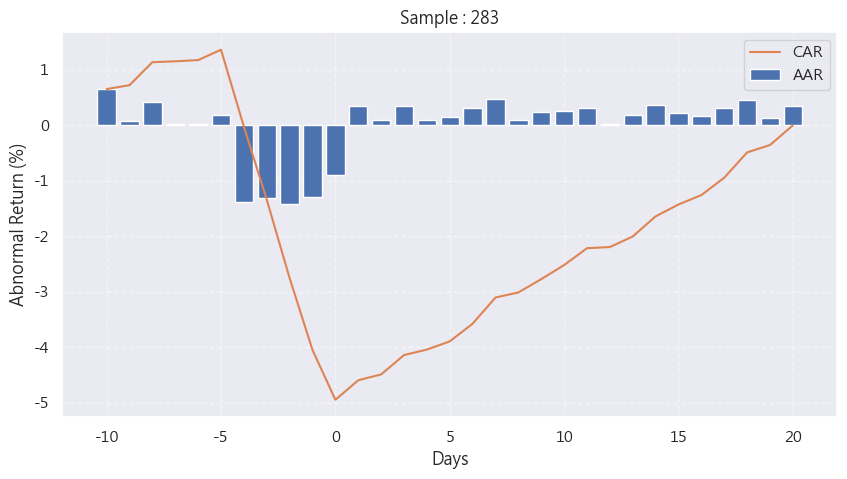

In [59]:
barckward_days = 10
forward_days = 20
df_AR = pd.DataFrame(index=list(range(-barckward_days,forward_days+1)))
marketdates = data.sort_index(ascending=True).groupby(data.index).first().index.to_list()
pick_date = df_group.index.to_list()
for d in tqdm(random.sample(pick_date,int(len(pick_date)/2))):
    group = df_group.loc[d]['股票代號']
    for stock in group:
        df_stock = data[data['股票代號']==stock][['收盤價','開盤價']].sort_index(ascending=True)
        df_stock['Market Close'] = df_index['收盤價']
        df_stock['Market Open'] = df_index['開盤價']
        # print(df_stock)
        df_stock.columns = ['Stock Close','Stock Open','Market Close','Market Open']
        df_stock['Stock Return'] = (df_stock['Stock Close'] - df_stock['Stock Open'])/df_stock['Stock Open']
        df_stock['Market Return'] = (df_stock['Market Close'] - df_stock['Market Open'])/df_stock['Market Open']
        # df_stock['Stock Return'] =  df_stock['Stock Close'].pct_change()
        # df_stock['Market Return'] = df_stock['Market Close'].pct_change()
        df_AR[str(stock)+':'+str(d)[:10]] = event_study(df_stock,'Market Return','Stock Return',marketdates,str(d),barckward_days,forward_days)
df_AR = df_AR.dropna(axis=1)
df_AR['AAR'] = df_AR.mean(axis=1)
df_AR['CAR'] = df_AR['AAR'].cumsum()
next_day = pd.Series(df_AR.loc[1])
acc = (len(next_day[next_day>0])/len(next_day))*100
print(f'Day Trading acc : {acc} %')
plt.figure(figsize=(10,5))
plt.title(f'Sample : {len(df_AR.columns[:-2])}')
plt.xlabel('Days')
plt.ylabel('Abnormal Return (%)')
plt.grid(True,alpha=0.5,linestyle = '--')
plt.bar(df_AR.index,df_AR['AAR']*100,label='AAR')
plt.plot(df_AR['CAR']*100,label='CAR',color='C01')
plt.legend()

In [60]:
start = '2020-01-01'
end = marketdates[-1]
df_range = df_group.loc[start:end]
for d in df_range.index:
    df_range.loc[d,'當日張數'] = int(5000000/(data.loc[(data.index==d)&(data['股票代號'].isin(df_range.loc[d]['股票代號']))]['收盤價'].sum()*1000))
df_range

,股票代號,當日張數
日期,,
2020-11-02,[3037.0],76.0
2020-11-03,[3037.0],75.0
2020-11-04,"[1513.0, 3037.0]",42.0
2020-11-05,[1513.0],99.0
2020-11-09,[3653.0],17.0
...,...,...
2025-05-16,[6757.0],52.0
2025-06-06,[2439.0],43.0
2025-06-09,[2439.0],44.0


In [61]:
#持有時間
n = 20
stoploss=0.15
stopprofit=0.20
amount = 5000000

In [62]:
# 等金額
df_profit = pd.DataFrame()
marketdates = data.sort_index(ascending=True).groupby(data.index).first().index.to_list()
now = marketdates[-1]
df_daily_group = df_range.groupby(df_range.index)['股票代號'].apply(list).to_frame()
dates = df_daily_group.index
total_trade =0
win_trade = 0
stoploss_times=0
stopprofit_times=0
out_times=0

for d in tqdm(dates[:]):
    today = marketdates.index(d)
    yesterday = marketdates[today-1]
    if d<now:
        tommorw = marketdates[today+1]
    else:
        break
    group = df_daily_group.loc[d,'股票代號']
    same_num = df_range.loc[d]['當日張數']
    amount_per = amount/len(group[0])
    total = 0
    win = 0
    if today+n<len(marketdates):
        next_ndays = marketdates[today+n]
        for stock in group[0]:
            # if stock in df_daily_group.loc[d].rolling(3,min_peroid=1)
            window = data[(data.index>=d)&(data.index<=next_ndays)&(data['股票代號']==stock)]
            ## Long
            if len(window)>=n:
                buy_price_yes = window.loc[d]['收盤價']
                buy_price = window.loc[tommorw]['開盤價']*(1+0.004425)
                num = amount_per/(buy_price_yes*1000)
               
                for w in range(1,len(window)-1):
                    stopprofit_cond = (window.iloc[w]['最高價']>buy_price*(1+stopprofit))
                    # stopprofit_cond = (window.iloc[w]['最高價']>=(window.iloc[w-1]['收盤價']*(1+stopprofit)))&(window.iloc[w]['最高價']>buy_price*(1+0.15))
                    stoploss_cond = (window.iloc[w]['最低價']<=buy_price*(1-stoploss))
                    out_cond = (window.iloc[w]['調整報酬率']>0.025)&(window.iloc[w]['週轉率(%)']<2)&(window.iloc[w]['收盤價']<window.iloc[w]['SMA'])
                    if (stopprofit_cond) or (stoploss_cond)or (out_cond):
                    # if window.iloc[w]['最高價']>=window.iloc[w-1]['收盤價']*(1+0.9)  or (window.iloc[w]['最低價']<=buy_price*(1-0.25)) or ((window.iloc[w].name!=tommorw)&(window.iloc[w-1]['週轉率(%)']/window.iloc[w-2]['週轉率(%)']-1>0)&(window.iloc[w]['開盤價']>window.iloc[w-1]['最高價'])):
                    # if window.iloc[w]['最高價']>=window.iloc[w-1]['收盤價']*(1+0.9) or ((window.iloc[w].name!=tommorw)&(window.iloc[w]['週轉率(%)']/max(1,window.iloc[w-1]['週轉率(%)'])-1>5)&(window.iloc[w-1]['最高價']<window.iloc[w]['開盤價'])) or (window.iloc[w]['最低價']<=buy_price*(1-0.30)):  
                        if stopprofit_cond:
                            stopprofit_times+=1
                            # sell_date = window.iloc[w].name
                            # sell_price = buy_price*(1+stopprofit)*(1-0.001425)
                            # break
                            if window.iloc[w]['最高價']==window.iloc[w]['收盤價']:
                                sell_price = window.iloc[w+1]['開盤價']*(1-0.001425)
                                sell_date = window.iloc[w+1].name
                                break
                            else:
                                sell_price = window.iloc[w-1]['收盤價']*(1+stopprofit)*(1-0.001425)
                                sell_date = window.iloc[w].name
                                break
                        elif stoploss_cond:
                            stoploss_times+=1
                            sell_price = buy_price*(1-stoploss)*(1-0.001425)
                            sell_date = window.iloc[w].name
                            break
                        else:
                            out_times+=1
                            sell_price = window.iloc[w]['開盤價']*(1-0.001425)
                            sell_date = window.iloc[w].name
                            break
                    else:
                        sell_date = window.iloc[w+1].name
                        sell_price = window.iloc[w+1]['開盤價']*(1-0.001425)
                # print(tommorw,stock,buy_price,sell_date,sell_price)
                # total+=((sell_price-buy_price)*1000*same_num)
                total+=((sell_price-buy_price)*1000*num)
                total_trade+=1
                if (sell_price-buy_price)>0:
                    win+=1
                    win_trade+=1
    else:
        for stock in group[0]:
            window = data[(data.index>=d)&(data.index<=now)&(data['股票代號']==stock)]
            buy_price_yes = window.loc[d]['收盤價']
            buy_price = window.loc[tommorw]['開盤價']*(1+0.004425)
            num = amount_per/(buy_price_yes*1000)
            same_num = df_range.loc[d]['當日張數']
            # num = amount_per/(buy_price*1000)
            for w in range(1,len(window)-1):
                # stopprofit_cond = ((window.iloc[w]['最高價']>=window.iloc[w-1]['收盤價']*(1+stopprofit))&(window.iloc[w]['最高價']>buy_price)&(window.iloc[w]['週轉率(%)']<2))
                stopprofit_cond = (window.iloc[w]['最高價']>buy_price*(1+stopprofit))
                stoploss_cond = (window.iloc[w]['最低價']<=buy_price*(1-stoploss))
                out_cond = (window.iloc[w]['調整報酬率']>0.025)&(window.iloc[w]['週轉率(%)']<2)&(window.iloc[w]['收盤價']<window.iloc[w]['SMA'])
                if (stopprofit_cond) or (stoploss_cond) or (out_cond): 
                    if stopprofit_cond:
                        stopprofit_times+=1
                        # sell_date = window.iloc[w].name
                        # sell_price = buy_price*(1+stopprofit)*(1-0.001425)
                        # break
                        if window.iloc[w]['最高價']==window.iloc[w]['收盤價']:
                            sell_price = window.iloc[w+1]['開盤價']*(1-0.001425)
                            sell_date = window.iloc[w+1].name
                            break
                        else:
                            sell_price = window.iloc[w-1]['收盤價']*(1+stopprofit)*(1-0.001425)
                            sell_date = window.iloc[w].name
                            break
                    elif stoploss_cond:
                        stoploss_times+=1
                        sell_price = buy_price*(1-stoploss)*(1-0.001425)
                        sell_date = window.iloc[w].name
                        break
                    else:
                        out_times+=1
                        sell_price = window.iloc[w]['開盤價']*(1-0.001425)
                        sell_date = window.iloc[w].name
                        break
                else:
                    sell_price = window.loc[now]['收盤價']*(1-0.001425)
                    sell_date=now
            if len(window)==2:
                sell_price = window.loc[now]['收盤價']*(1-0.001425)
                sell_date=now
            print(tommorw,stock,buy_price,sell_date,sell_price)
            # total+=((sell_price-buy_price)*1000*same_num)
            total+=((sell_price-buy_price)*1000*num)
            total_trade+=1

    df_profit.loc[d,'Profit'] = total
    df_profit.loc[d,'win rate'] = (win/len(group[0]))*100
    df_profit.loc[d,'stocks'] = len(group[0])
df_profit['cumsum'] = df_profit['Profit'].cumsum()
df_profit['mdd'] = count_mdd(df_profit['cumsum'],len(df_profit))
# df_profit['cumprod'] = (df_profit['Profit']/5000000+1).cumprod()-1
# df_profit['ret'] = ((df_profit['Profit'].pct_change()+1).cumprod()-1)
df_profit

100%|██████████| 371/371 [00:05<00:00, 67.16it/s]

2025-07-07 00:00:00 3376.0 209.42261249999999 2025-07-08 00:00:00 205.70645
2025-07-08 00:00:00 3019.0 124.04648749999998 2025-07-08 00:00:00 123.3240125


,Profit,win rate,stocks,cumsum,mdd
2020-11-02,2.109752e+06,100.0,1.0,2.109752e+06,0.000000e+00
2020-11-03,2.036874e+06,100.0,1.0,4.146625e+06,0.000000e+00
2020-11-04,1.761117e+06,100.0,2.0,5.907743e+06,0.000000e+00
2020-11-05,7.365894e+05,100.0,1.0,6.644332e+06,0.000000e+00
2020-11-09,-2.925000e+04,0.0,1.0,6.615082e+06,-2.925000e+04
...,...,...,...,...,...
2025-05-16,-1.354461e+04,0.0,1.0,1.013328e+08,-5.127275e+06
2025-06-06,-5.108533e+04,0.0,1.0,1.012817e+08,-5.178360e+06
2025-06-09,-1.393541e+05,0.0,1.0,1.011424e+08,-5.317714e+06
2025-07-04,-8.933083e+04,0.0,1.0,1.010530e+08,-5.407045e+06


Stop Loss : 15.0 %
Total Trade : 563
Daily Stocks : 2
Daily Stocks (Max): 8.0, Date : 2023-08-04 00:00:00
Total Backtest Win Rate : 59 %
PL Ratio : 12.6992
Mean PL : 1.72
Expect : 0.6349
Trade Freq : 31.0%
Month Freqency: 7, max: 15, min: 0
Year Freqency: 62
Times of Stoploss : 100 , Times of Stopprofit : 110, Times of Condition Out : 182
Uneven: 2025-06-11 00:00:00


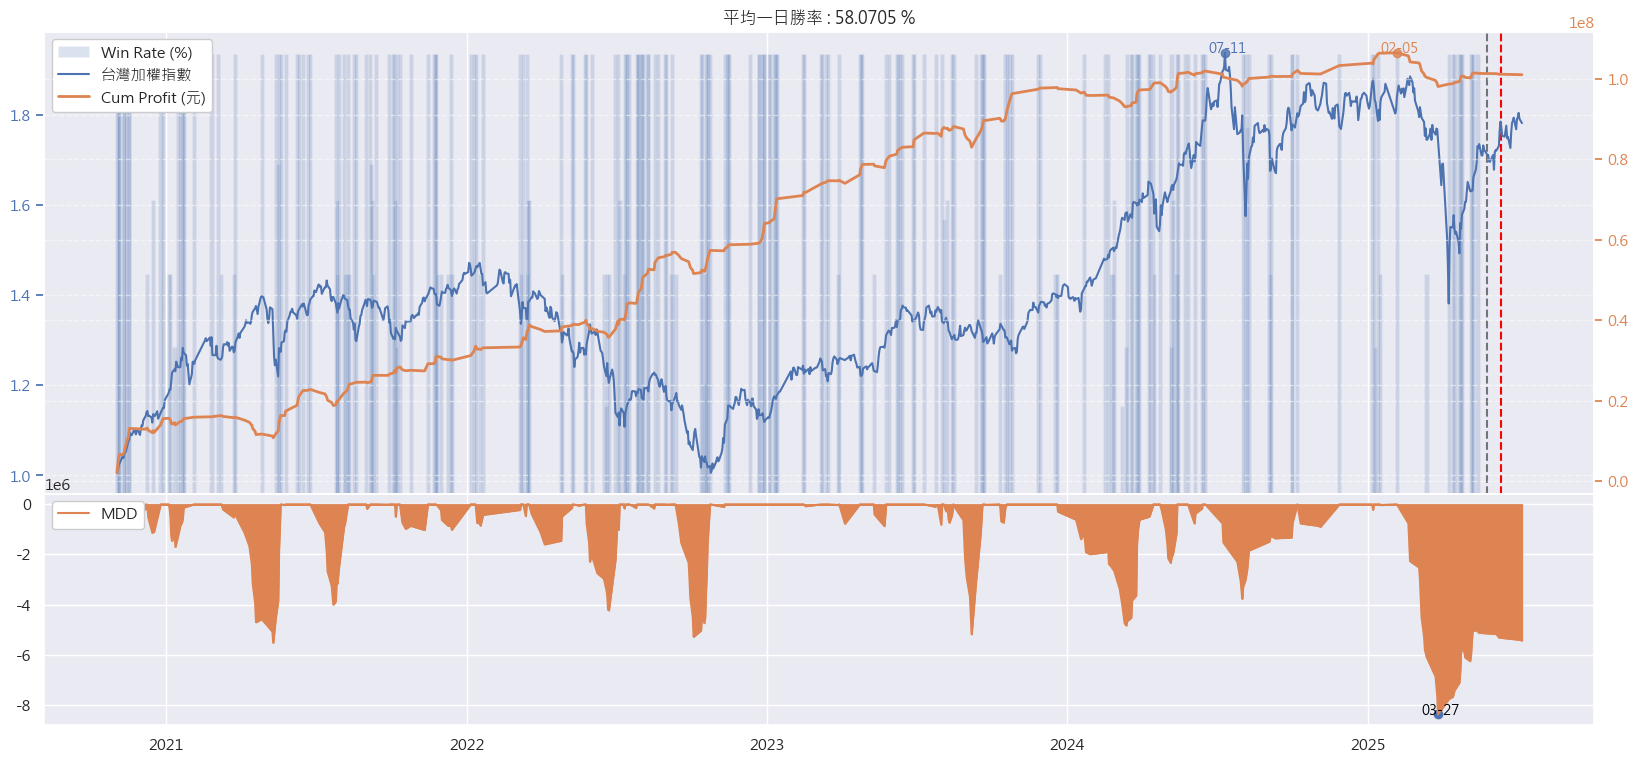

In [63]:
mean_unit_profit, mean_win_rate,mean_unit = df_profit[['Profit','win rate','stocks']].mean().values
df_TW = (df_index[(df_index.index>=df_profit.iloc[0].name)&(df_index.index<=df_profit.iloc[-1].name)]['收盤價'].pct_change()+1).cumprod()
df_win = df_profit[df_profit['Profit']>0]
df_lose = df_profit[df_profit['Profit']<0]
mean_win = df_win['Profit'].mean()
mean_lose = df_lose['Profit'].mean()
max_unit = df_profit['stocks'].max()
pl = np.where(mean_win>mean_lose,round(abs(mean_win/mean_lose),2),round(mean_win/mean_lose,2))
win_pro = len(df_win)/len(df_profit)
exp = round(win_pro*pl-(1-win_pro),4)
max_unit_date = df_profit[df_profit['stocks'] == df_profit['stocks'].max()].index[0]
df_month = df_range.groupby([pd.Grouper(freq='ME')]).count()
df_year = df_range.groupby([pd.Grouper(freq='Y')]).count()
month_mean = round(df_month['股票代號'].mean())
year_mean = round(df_year['股票代號'].mean())
month_max = df_month['股票代號'].max()
month_min = df_month['股票代號'].min()
print(f'Stop Loss : {stoploss*100} %')
print(f'Total Trade : {total_trade}')
print(f'Daily Stocks : {round(mean_unit)}')
print(f'Daily Stocks (Max): {max_unit}, Date : {max_unit_date}')
print(f'Total Backtest Win Rate : {round(win_trade*100/total_trade)} %')
print(f'PL Ratio : '+str(abs(round(df_profit['cumsum'].max()/df_profit['mdd'].min(),4))))
print(f'Mean PL : {pl}')
print(f'Expect : {exp}')
print(f'Trade Freq : '+ str(round(len(df_daily_group)/len(marketdates),2)*100) + '%')
print(f'Month Freqency: {month_mean}, max: {month_max}, min: {month_min}')
print(f'Year Freqency: {year_mean}')
print(f'Times of Stoploss : {stoploss_times} , Times of Stopprofit : {stopprofit_times}, Times of Condition Out : {out_times}')
print(f'Uneven: {marketdates[-20]}')

fig,ax1 = plt.subplots(2,figsize=(20,9),sharex=True,gridspec_kw={'height_ratios': [2,1]})
fig.subplots_adjust(hspace = 0)
# ax1[0].set_xticks(pd.date_range(start=datetime.strftime(df_profit.iloc[0].name,'%Y-%m-%d'), end=datetime.strftime(df_profit.iloc[-1].name,'%Y-%m-%d'), freq="M"))
# ax1[0].set_xticklabels(pd.date_range(start=datetime.strftime(df_profit.iloc[0].name,'%Y-%m-%d'), end=datetime.strftime(df_profit.iloc[-1].name,'%Y-%m-%d'), freq="M"),rotation=90)
# ax1[0].set_title(f'(若該日有交易)平均一日 : {round(mean_unit_profit,4)}元'+'\n'+f'平均一日勝率 : {round(mean_win_rate,4)} %')
ax1[0].set_title(f'平均一日勝率 : {round(mean_win_rate,4)} %')

ax2 = ax1[0].twinx()
ax3 = ax2.twinx()
ax2.grid(True,linestyle='--',alpha=0.5)
ax3.grid(True,linestyle='--',alpha=0.5)
ax1[0].get_yaxis().set_visible(False)
ax1[0].bar(df_profit.index,df_profit['win rate'],alpha=0.2,width=5,label='Win Rate (%)',linewidth=0.5)
ax2.axvline(marketdates[-20],color='red',linestyle='--')
ax2.axvline(pd.to_datetime('2025-05-26'),color='black',linestyle='--',alpha=0.5)
ax2.plot(df_TW,label='台灣加權指數',color="C10")
ax3.plot(df_profit['cumsum'],color='C01',label='Cum Profit (元)',linewidth=2)
ax2.scatter(df_TW[df_TW==df_TW.max()].index,df_TW.max(),color='C10',alpha=0.8)
ax3.scatter(df_profit[df_profit['cumsum']==df_profit['cumsum'].max()].index,df_profit[df_profit['cumsum']==df_profit['cumsum'].max()]['cumsum'],color='C01',alpha=0.8)
ax2.text(df_TW[df_TW==df_TW.max()].index-pd.Timedelta(days=20),df_TW.max(),str(df_TW[df_TW==df_TW.max()].index.values[0])[5:10],color='C10',fontsize=10)
ax3.text(df_profit[df_profit['cumsum']==df_profit['cumsum'].max()].index-pd.Timedelta(days=20),df_profit[df_profit['cumsum']==df_profit['cumsum'].max()]['cumsum'],str(df_profit[df_profit['cumsum']==df_profit['cumsum'].max()].index.values[0])[5:10],color='C01',fontsize=10)
# ax3.plot(df_profit['cumprod'],color='C01',label='Cum Profit (%)',linewidth=2)
ax3.tick_params(axis='y', colors='C01')
ax2.tick_params(axis='y', colors='C10')

lines, labels = ax1[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1[0].legend(lines + lines2 + lines3, labels + labels2 + labels3 , loc='upper left',facecolor='white',framealpha=1)


ax1[1].plot(df_profit.index,df_profit['mdd'],label='MDD',color='C01')
ax1[1].fill_between(df_profit.index,df_profit['mdd'],color='C01')
ax1[1].scatter(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index,df_profit['mdd'].min(),color='C10')
# ax1[1].text(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index,df_profit['mdd'].min(),round(df_profit['mdd'].min(),2),color='C10')
ax1[1].text(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index-pd.Timedelta(days=20),df_profit['mdd'].min()+0.1,str(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index.values[0])[5:10],color='Black',fontsize=10)
ax1[1].legend(loc='upper left',facecolor='white',framealpha=1)



In [64]:
# 計算每日損益
df_result = pd.DataFrame()
ii=0
marketdates_range = [i for i in marketdates if (i>=pd.to_datetime(start))&(i<=pd.to_datetime(end))]
for today in df_range.index[:]:
    today_index = marketdates_range.index(today)
    if today<= marketdates_range[-n-1]:
        tommorw = marketdates_range[today_index+1]
        next_ndays = marketdates_range[today_index+n]
        group = df_range.loc[today]['股票代號']
        amount_per = amount/len(group)
        for stock in group:
            window = data[(data.index>=today)&(data.index<=next_ndays)&(data['股票代號']==stock)]
            buy_date = tommorw
            buy_OHLC = '開盤價'
            try:
                buy_price = window.loc[buy_date][buy_OHLC]*(1+0.004425)
                buy_price_yes = window.loc[today]['收盤價']
            except:
                buy_date = window.iloc[1].name
                buy_price = window.iloc[1][buy_OHLC]*(1+0.004425)
            num = int(amount_per/(buy_price_yes*1000))
            # num = int(amount_per/(buy_price*1000))
            # same_num = df_range.loc[today]['當日張數']
            for w in range(1,len(window)-1):
                stopprofit_cond = (window.iloc[w]['最高價']>buy_price*(1+stopprofit)*(1+window.iloc[w-1]['指數變化率']))
                # stopprofit_cond = ((window.iloc[w]['最高價']>=window.iloc[w-1]['收盤價']*(1+stopprofit))&(window.iloc[w]['最高價']>buy_price))
                stoploss_cond = (window.iloc[w]['最低價']<=buy_price*(1-stoploss))
                out_cond = (window.iloc[w]['調整報酬率']>0.025)&(window.iloc[w]['週轉率(%)']<2)&(window.iloc[w]['收盤價']<window.iloc[w]['SMA'])
                # out_cond = (window.iloc[w]['調整報酬率']>0.05)&(window.iloc[w]['週轉變化率']<window.iloc[w]['週轉變化率_first'])&(window.iloc[w]['週轉率(%)']<2)&(window.iloc[w]['收盤價']<window.iloc[w]['SMA'])
                if (stopprofit_cond) or (stoploss_cond)or (out_cond):
                    if stopprofit_cond:
                        # sell_date = window.iloc[w].name
                        # sell_OHLC = '收盤價'
                        # sell_position = '停利1'
                        # break
                        if window.iloc[w]['最高價']==window.iloc[w]['收盤價']:
                            sell_date = window.iloc[w+1].name
                            sell_OHLC = '開盤價'
                            sell_position = '停利1'
                            break
                        else:
                            sell_date = window.iloc[w].name
                            sell_OHLC = '收盤價'
                            sell_position = '停利2'
                            break
                    elif stoploss_cond:
                        sell_date = window.iloc[w].name
                        sell_OHLC = '收盤價'
                        sell_position = '停損'
                        break
                    else:
                        sell_date = window.iloc[w+1].name
                        sell_OHLC = '開盤價'
                        sell_position = '條件出場'
                        break
                else:
                    sell_date = window.iloc[-1].name
                    sell_OHLC = '開盤價'
                    sell_position = '一般出場'
            df_result.loc[ii,'Stock'] = stock
            df_result.loc[ii,'Num'] = num
            # df_result.loc[ii,'Num'] = same_num
            df_result.loc[ii,'BuyDate'] = buy_date
            df_result.loc[ii,'BuyOHLC'] = buy_OHLC
            df_result.loc[ii,'SellDate'] = sell_date
            df_result.loc[ii,'BuyDate'] = buy_date
            df_result.loc[ii,'SellOHLC'] = sell_OHLC
            df_result.loc[ii,'SellPosition'] = sell_position
            ii+=1
    else:
        group = df_range.loc[today]['股票代號']
        amount_per = amount/len(group)
        today_index = marketdates_range.index(today)
        if today_index ==len(marketdates_range)-1:
            tommorw=today
        else:
            tommorw = marketdates_range[today_index+1]
        for stock in group:
            window = data[(data.index>=today)&(data.index<=marketdates_range[-1])&(data['股票代號']==stock)]
            buy_date = tommorw
            buy_OHLC = '開盤價'
            buy_price = window.loc[buy_date][buy_OHLC]*(1+0.004425)
            buy_price_yes = window.loc[today]['收盤價']
            num = int(amount_per/(buy_price_yes*1000))
            # num = int(amount_per/(buy_price*1000))
            # same_num = df_range.loc[today]['當日張數']
            if buy_date!=marketdates_range[-1]:
                for w in range(1,len(window)-1):
                    stopprofit_cond = (window.iloc[w]['最高價']>buy_price*(1+stopprofit)*(1+window.iloc[w-1]['指數變化率']))
                    # stopprofit_cond = ((window.iloc[w]['最高價']>=window.iloc[w-1]['收盤價']*(1+stopprofit))&(window.iloc[w]['最高價']>buy_price))
                    stoploss_cond = (window.iloc[w]['最低價']<=buy_price*(1-stoploss))
                    out_cond = (window.iloc[w]['調整報酬率']>0.025)&(window.iloc[w]['週轉率(%)']<2)&(window.iloc[w]['收盤價']<window.iloc[w]['SMA'])
                    # out_cond = (window.iloc[w]['調整報酬率']>0.05)&(window.iloc[w]['週轉變化率']<window.iloc[w]['週轉變化率_first'])&(window.iloc[w]['週轉率(%)']<2)&(window.iloc[w]['收盤價']<window.iloc[w]['SMA'])
                    if (stopprofit_cond) or (stoploss_cond) or (out_cond):
                        if stopprofit_cond:
                            # sell_date = window.iloc[w].name
                            # sell_OHLC = '收盤價'
                            # sell_position = '停利1'
                            # break
                            if window.iloc[w]['最高價']==window.iloc[w]['收盤價']:
                                sell_date = window.iloc[w+1].name
                                sell_OHLC = '開盤價'
                                sell_position = '停利1'
                                break
                            else:
                                sell_date = window.iloc[w].name
                                sell_OHLC = '收盤價'
                                sell_position = '停利2'
                                break
                        elif stoploss_cond:
                            sell_date = window.iloc[w].name
                            sell_OHLC = '收盤價'
                            sell_position = '停損'
                            break
                        else:
                            sell_date = window.iloc[w+1].name
                            sell_OHLC = '開盤價'
                            sell_position = '條件出場'
                            break
                    else:
                        sell_date = marketdates_range[-1]
                        sell_OHLC = '收盤價'
                        sell_position = '未平倉'
            else :
                sell_date = marketdates_range[-1]
                sell_OHLC = '收盤價'
                sell_position = '未平倉'
            df_result.loc[ii,'Stock'] = stock
            df_result.loc[ii,'Num'] = num
            # df_result.loc[ii,'Num'] = same_num
            df_result.loc[ii,'BuyDate'] = buy_date
            df_result.loc[ii,'BuyOHLC'] = buy_OHLC
            df_result.loc[ii,'SellDate'] = sell_date
            df_result.loc[ii,'SellOHLC'] = sell_OHLC
            df_result.loc[ii,'SellPosition'] = sell_position
            ii+=1
df_result
            

,Stock,Num,BuyDate,BuyOHLC,SellDate,SellOHLC,SellPosition
0,3037.0,76.0,2020-11-03,開盤價,2020-11-24,收盤價,停利2
1,3037.0,75.0,2020-11-04,開盤價,2020-11-24,收盤價,停利2
2,1513.0,51.0,2020-11-05,開盤價,2020-12-01,收盤價,停利2
3,3037.0,36.0,2020-11-05,開盤價,2020-11-25,收盤價,停利2
4,1513.0,99.0,2020-11-06,開盤價,2020-12-03,開盤價,一般出場
...,...,...,...,...,...,...,...
558,6757.0,52.0,2025-05-19,開盤價,2025-06-04,開盤價,條件出場
559,2439.0,43.0,2025-06-09,開盤價,2025-07-04,開盤價,一般出場
560,2439.0,44.0,2025-06-10,開盤價,2025-07-07,開盤價,一般出場
561,3376.0,24.0,2025-07-07,開盤價,2025-07-08,收盤價,未平倉


In [65]:
# 每日損益回測

def Backtest(df,marketdates):
    ''' 
    df: Dataframe which contain stocks, buy,sell details
    '''
    df_backtest = pd.DataFrame(index=marketdates)
    df_delta = pd.DataFrame(index=marketdates)
    for i in tqdm(range(len(df[:]))):
        row = df.iloc[i]
        stock = row['Stock']
        num = row['Num']
        buy_date = row['BuyDate']
        buy_OHLC = row['BuyOHLC']
        sell_date = row['SellDate']
        sell_OHLC = row['SellOHLC']
        sell_condition = row['SellPosition']
        window = data.loc[(data.index>=buy_date)&(data.index<=sell_date)&(data['股票代號']==stock)]
        # print(stock,buy_date,sell_date)
        buy_price = window.loc[buy_date][buy_OHLC]*(1+0.004425)
        window['profit'] = (window['收盤價']*(1-0.001425)-buy_price)*1000*num
        window['Delta'] = window['收盤價']*1000*num
        if sell_condition=='停利1':
            window.loc[sell_date,'profit'] = (window.loc[sell_date][sell_OHLC]*(1-0.001425) - buy_price)*1000*num
            window.loc[sell_date,'Delta']  =  window.loc[sell_date][sell_OHLC]*(1-0.001425)*1000*num
            # window.loc[sell_date,'profit'] = (buy_price*(1+stopprofit)*(1-0.001425)-buy_price)*1000*num
        elif sell_condition=='停利2':
            window.loc[sell_date,'profit'] = (window.loc[sell_date][sell_OHLC]*(1+stopprofit)*(1-0.001425) - buy_price)*1000*num
            window.loc[sell_date,'Delta']  =  window.loc[sell_date][sell_OHLC]*(1+stopprofit)*(1-0.001425)*1000*num
        elif sell_condition=='停損':
            window.loc[sell_date,'profit'] = (buy_price*(1-stoploss)*(1-0.001425) - buy_price)*1000*num
            window.loc[sell_date,'Delta']  =  buy_price*(1-stoploss)*(1-0.001425)*1000*num
        elif sell_condition=='條件出場':
            window.loc[sell_date,'profit'] = (window.loc[sell_date][sell_OHLC]*(1-0.001425) - buy_price)*1000*num
            window.loc[sell_date,'Delta']  =  window.loc[sell_date][sell_OHLC]*(1-0.001425)*1000*num
        df_backtest[str(stock)+str(i)] = window[['profit']]
        df_delta[str(stock)+str(i)] = window[['Delta']]

    df_delta = df_delta.fillna(0)
    df_delta['Delta'] = df_delta.sum(axis=1)
    df_backtest = df_backtest.fillna(method='ffill')
    df_backtest = df_backtest.fillna(0)
    df_backtest['Profit'] = df_backtest.sum(axis=1)
    df_backtest['daily_profit'] = df_backtest['Profit'] - df_backtest['Profit'].shift(1)
    # df_backtest['Pct'] = np.where(df_backtest['Profit'].shift(1)!=0,df_backtest['Profit']/df_backtest['Profit'].shift(),df_backtest['Profit']/amount)
    # df_backtest['Return'] = (df_backtest['Pct']+1).cumprod()
    df_backtest['Mdd'] = count_mdd(df_backtest['Profit'],len(df_backtest))
    df_backtest['Return'] = df_backtest['Profit']/amount*100
    return df_backtest,df_delta

df_backtest,df_delta = Backtest(df_result,marketdates_range)
df_backtest['Daily'] = data['Daily'].groupby('日期').first()
df_backtest


100%|██████████| 563/563 [00:02<00:00, 188.65it/s]


,3037.00,3037.01,1513.02,3037.03,1513.04,3653.05,3653.06,3653.07,1513.08,1513.09,...,6757.0558,2439.0559,2439.0560,3376.0561,3019.0562,Profit,daily_profit,Mdd,Return,Daily
2020-09-01,0.00,0.000,0.000000e+00,0.000,0.0000,0.0000,0.0000,0.0000,0.000000e+00,0.000000e+00,...,0.00,0.0000,0.00,0.0,0.0,0.000000e+00,NaN,0.000000e+00,0.000000,1
2020-09-02,0.00,0.000,0.000000e+00,0.000,0.0000,0.0000,0.0000,0.0000,0.000000e+00,0.000000e+00,...,0.00,0.0000,0.00,0.0,0.0,0.000000e+00,0.000,0.000000e+00,0.000000,1
2020-09-03,0.00,0.000,0.000000e+00,0.000,0.0000,0.0000,0.0000,0.0000,0.000000e+00,0.000000e+00,...,0.00,0.0000,0.00,0.0,0.0,0.000000e+00,0.000,0.000000e+00,0.000000,1
2020-09-04,0.00,0.000,0.000000e+00,0.000,0.0000,0.0000,0.0000,0.0000,0.000000e+00,0.000000e+00,...,0.00,0.0000,0.00,0.0,0.0,0.000000e+00,0.000,0.000000e+00,0.000000,1
2020-09-07,0.00,0.000,0.000000e+00,0.000,0.0000,0.0000,0.0000,0.0000,0.000000e+00,0.000000e+00,...,0.00,0.0000,0.00,0.0,0.0,0.000000e+00,0.000,0.000000e+00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02,2391379.33,2322247.875,1.006310e+06,1082580.804,771683.9625,-19358.1125,302793.7375,436382.2625,1.915197e+06,1.986047e+06,...,-80885.74,-93462.1125,-29343.60,0.0,0.0,1.033835e+08,86876.025,-6.349151e+06,2067.670557,1
2025-07-03,2391379.33,2322247.875,1.006310e+06,1082580.804,771683.9625,-19358.1125,302793.7375,436382.2625,1.915197e+06,1.986047e+06,...,-80885.74,-50523.3875,14593.70,0.0,0.0,1.034704e+08,86876.025,-6.262274e+06,2069.408078,1
2025-07-04,2391379.33,2322247.875,1.006310e+06,1082580.804,771683.9625,-19358.1125,302793.7375,436382.2625,1.915197e+06,1.986047e+06,...,-80885.74,-222278.2875,-161155.50,0.0,0.0,1.031229e+08,-347504.100,-6.609779e+06,2062.457996,1
2025-07-07,2391379.33,2322247.875,1.006310e+06,1082580.804,771683.9625,-19358.1125,302793.7375,436382.2625,1.915197e+06,1.986047e+06,...,-80885.74,-222278.2875,-95249.55,-77205.0,0.0,1.031116e+08,-11299.050,-6.621078e+06,2062.232015,1


Stop Loss : 15.0 %
Stop Profit : 20.0 %
Total Trade : 563
Mean win rate : 47.45 % 
Monthly mean Profit : (-292312.0, 646351.0, 3436917.5) 元
Monthly mean Return : (-1.48, 2.59, 12.87) %
Monthly max loss : -5,550,250 (-11.10) %, Month : 2025-03
Monthly max profit : 13,524,528 (27.05) % , Month : 2022-08
PL Ratio : 46.0364
Expect : 0.6349
Times of Stoploss : 100 , Times of Stopprofit : 111, Times of Condition Out : 181
日平均 Delta : 19,229,537
Uneven: 2025-07-07 00:00:00
以實現損益: 103,111,601
未實現損益: -40,882


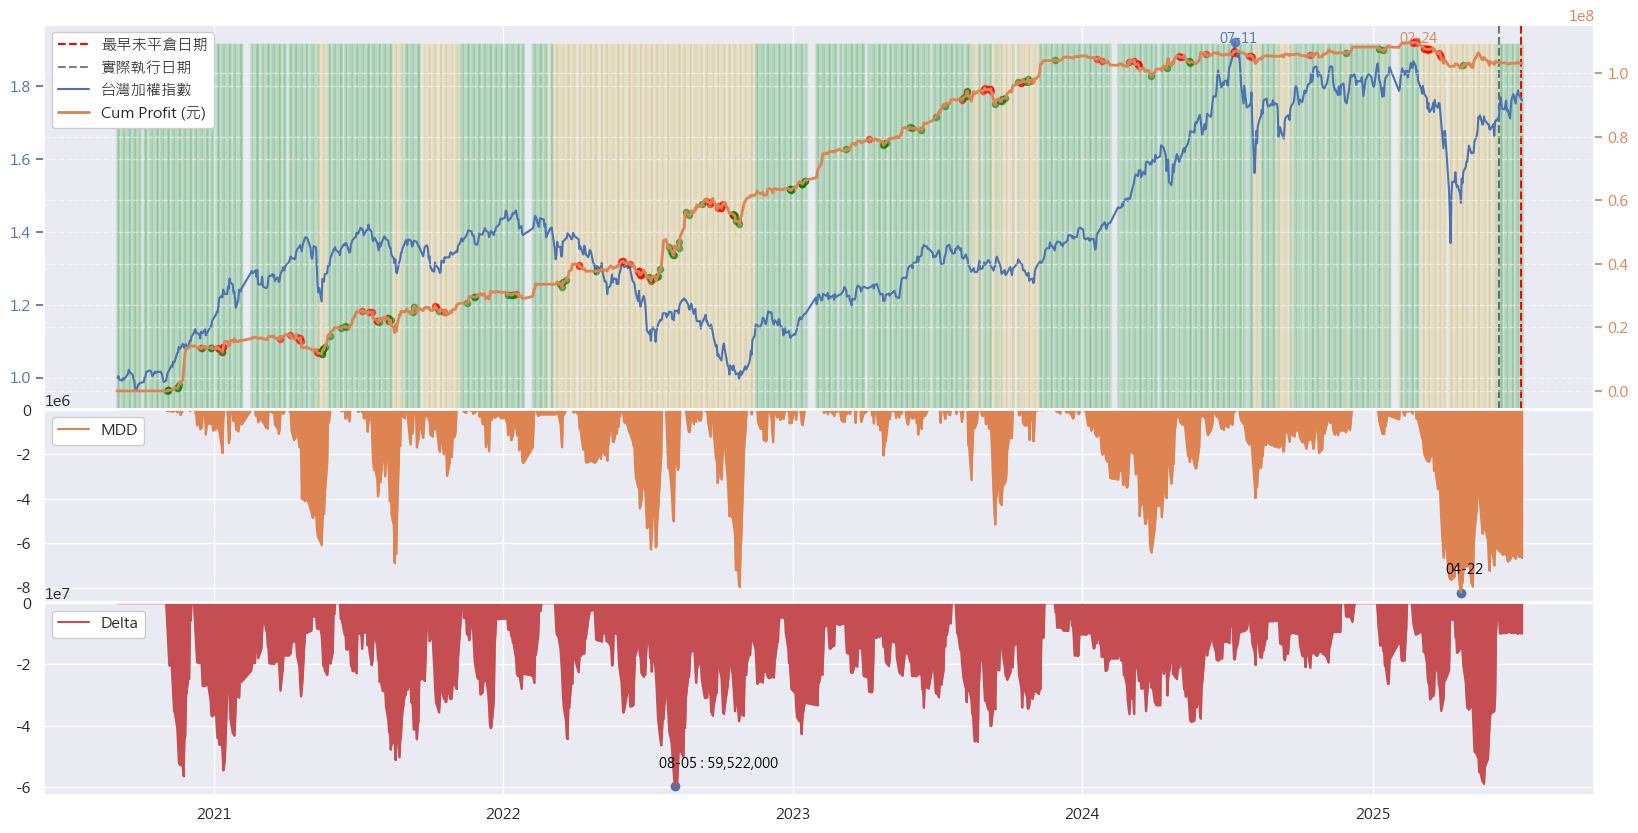

In [66]:
df_TW = (df_index[(df_index.index>=df_backtest.index[0])&(df_index.index<=pd.to_datetime(end))]['收盤價'].pct_change()+1).cumprod()
df_month_return = pd.concat([df_backtest[['Profit']].groupby(pd.Grouper(freq='ME')).first(),df_backtest[['Profit']].groupby(pd.Grouper(freq='ME')).last(),df_month[['當日張數']]],axis=1)
df_month_return.columns = ['Start','End','Times']
df_month_return['Profit'] = round(df_month_return['End'] - df_month_return['Start'])
df_month_return['Return'] = round((df_month_return['Profit']/(np.where(df_month_return['Times']!=0,df_month_return['Times'],1)*5000000))*100,2)
stopprofit_times = len(df_result[(df_result['SellPosition']=='停利1')|(df_result['SellPosition']=='停利2')])
stoploss_times = len(df_result[(df_result['SellPosition']=='停損')])
condition_times = len(df_result[(df_result['SellPosition']=='條件出場')])
try:
    Unevendate = df_result[df_result['SellPosition']=='未平倉']['BuyDate'].sort_values(ascending=True).to_list()[0]
except:
    Unevendate = df_backtest.index[-1]
total_trade = len(df_result)
month_profit_q1,month_profit_q2,month_profit_q3 = df_month_return['Profit'].quantile(0.25),df_month_return['Profit'].quantile(0.5),df_month_return['Profit'].quantile(0.75)
month_return_q1,month_return_q2,month_return_q3 = df_month_return['Return'].quantile(0.25),df_month_return['Return'].quantile(0.5),df_month_return['Return'].quantile(0.75)
month_max_loss = df_month_return['Profit'].min()
month_max_loss_pct = df_month_return[df_month_return['Profit']==month_max_loss]['Return'].values[0]
month_max_loss_date = str(df_month_return[df_month_return['Profit']==month_max_loss].index[0])[:7]
month_max_win = df_month_return['Profit'].max()
month_max_win_pct = df_month_return[df_month_return['Profit']==month_max_win]['Return'].values[0]
month_max_win_date = str(df_month_return[df_month_return['Profit']==month_max_win].index[0])[:7]
mean_win_rate = round((len(df_backtest[df_backtest['daily_profit']>0])/len(df_backtest))*100,2)
already_profit = round(df_backtest.loc[Unevendate]['Profit'],2)
unready_profit = round(df_backtest.iloc[-1]['Profit'] - already_profit,2)
mean_delta = df_delta['Delta'].mean()
print(f'Stop Loss : {stoploss*100} %')
print(f'Stop Profit : {stopprofit*100} %')
print(f'Total Trade : {total_trade}')
print(f'Mean win rate : {mean_win_rate} % ')
print(f'Monthly mean Profit : {month_profit_q1,month_profit_q2,month_profit_q3} 元')
print(f'Monthly mean Return : {month_return_q1,month_return_q2,month_return_q3} %')
print(f'Monthly max loss : {month_max_loss:,.0f} ({month_max_loss_pct:.2f}) %, Month : {month_max_loss_date}')
print(f'Monthly max profit : {month_max_win:,.0f} ({month_max_win_pct:.2f}) % , Month : {month_max_win_date}')
print(f'PL Ratio : '+str(abs(round(df_backtest['Profit'].mean()/df_backtest['Mdd'].mean(),4))))
print(f'Expect : {exp}')
print(f'Times of Stoploss : {stoploss_times} , Times of Stopprofit : {stopprofit_times}, Times of Condition Out : {condition_times}')
print(f'日平均 Delta : {mean_delta:,.0f}')
print(f'Uneven: {Unevendate}')
print(f'以實現損益: {already_profit:,.0f}')
print(f'未實現損益: {unready_profit:,.0f}')

fig,ax1 = plt.subplots(3,figsize=(20,10),sharex=True,gridspec_kw={'height_ratios': [2,1,1]})
fig.subplots_adjust(hspace = 0.005)
# ax1[0].set_title(f'(若該日有交易)平均一日 : {round(mean_unit_profit,4)}元'+'\n'+f'平均一日勝率 : {round(mean_win_rate,4)} %')
ax2 = ax1[0].twinx()
ax3 = ax2.twinx()
ax2.grid(True,linestyle='--',alpha=0.5)
ax3.grid(True,linestyle='--',alpha=0.5)
ax1[0].get_yaxis().set_visible(False)
color_map = {1: 'C02',-1: 'C08'}
ax1[0].bar(df_backtest.index,100,alpha=0.2,width=5,linewidth=1,color=[color_map[i] for i in df_backtest['Daily']])
ax2.axvline(Unevendate,color='red',linestyle='--',label='最早未平倉日期')
ax2.axvline(pd.to_datetime('2025-06-09'),color='black',linestyle='--',alpha=0.5,label='實際執行日期')
ax2.plot(df_TW,label='台灣加權指數',color="C10")
ax3.plot(df_backtest['Profit'],color='C01',label='Cum Profit (元)',linewidth=2)
# ax3.plot(df_backtest['Return'],color='C03',label='Cum Profit (%)',linewidth=2)
ax2.scatter(df_TW[df_TW==df_TW.max()].index,df_TW.max(),color='C10',alpha=0.8)
ax3.scatter(df_backtest[df_backtest['Profit']==df_backtest['Profit'].max()].index[-1],df_backtest[df_backtest['Profit']==df_backtest['Profit'].max()].iloc[-1]['Profit'],color='C01',alpha=0.8)
stoplossdates = df_result[(df_result['SellPosition']=='停損')]['BuyDate']
stopprofitdates = df_result[(df_result['SellPosition']=='停利1')|(df_result['SellPosition']=='停利2')]['BuyDate']
ax3.scatter(stoplossdates,df_backtest.loc[stoplossdates]['Profit'],color='Red',alpha=0.5,s=20)
ax3.scatter(stopprofitdates,df_backtest.loc[stopprofitdates]['Profit'],color='Green',alpha=0.5,s=20)
ax2.text(df_TW[df_TW==df_TW.max()].index-pd.Timedelta(days=20),df_TW.max(),str(df_TW[df_TW==df_TW.max()].index.values[0])[5:10],color='C10',fontsize=10)
ax3.text(df_backtest[df_backtest['Profit']==df_backtest['Profit'].max()].index[-1]-pd.Timedelta(days=20),df_backtest[df_backtest['Profit']==df_backtest['Profit'].max()].iloc[-1]['Profit'],str(df_backtest[df_backtest['Profit']==df_backtest['Profit'].max()].index.values[0])[5:10],color='C01',fontsize=10)
# ax3.plot(df_backtest['cumprod'],color='C01',label='Cum Profit (%)',linewidth=2)
ax3.tick_params(axis='y', colors='C01')
ax2.tick_params(axis='y', colors='C10')

lines, labels = ax1[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1[0].legend(lines + lines2 + lines3, labels + labels2 + labels3 , loc='upper left',facecolor='white',framealpha=1)


ax1[1].plot(df_backtest.index,df_backtest['Mdd'],label='MDD',color='C01')
ax1[1].fill_between(df_backtest.index,df_backtest['Mdd'],color='C01')
ax1[1].set_ylim(top=0)
ax1[2].plot(df_delta.index,-df_delta['Delta'],label='Delta',color='C03')
ax1[2].fill_between(df_delta.index,-df_delta['Delta'],color='C03')
ax1[2].set_ylim(top=0)
try:
    ax1[1].scatter(df_backtest[df_backtest['Mdd']==df_backtest['Mdd'].min()].index[-1],df_backtest['Mdd'].min(),color='C10')
except:
    pass
# ax1[1].text(df_backtest[df_backtest['Mdd']==df_backtest['Mdd'].min()].index,df_backtest['Mdd'].min(),round(df_backtest['Mdd'].min(),2),color='C10')
ax1[1].text(df_backtest[df_backtest['Mdd']==df_backtest['Mdd'].min()].index[-1]-pd.Timedelta(days=20),df_backtest['Mdd'].min(),str(df_backtest[df_backtest['Mdd']==df_backtest['Mdd'].min()].index.values[0])[5:10]+'\n',color='Black',fontsize=10)
ax1[1].legend(loc='upper left',facecolor='white',framealpha=1)
ax1[2].scatter(df_delta[df_delta['Delta']==df_delta['Delta'].max()].index[-1],-df_delta['Delta'].max(),color='C10')
ax1[2].text(df_delta[df_delta['Delta']==df_delta['Delta'].max()].index[-1]-pd.Timedelta(days=20),-df_delta['Delta'].max(),str(df_delta[df_delta['Delta']==df_delta['Delta'].max()].index.values[0])[5:10]+f" : {(df_delta['Delta'].max()):,.0f}\n ",color='Black',fontsize=10)
ax1[2].legend(loc='upper left',facecolor='white',framealpha=1)



<BarContainer object of 49 artists>

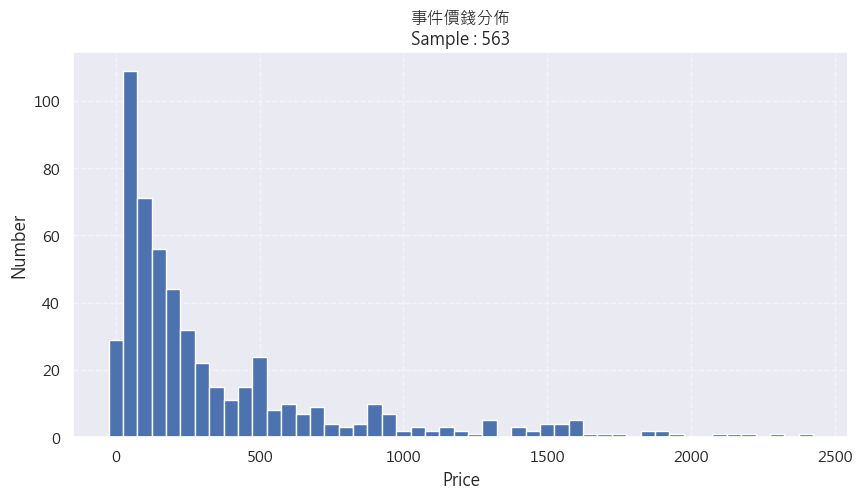

In [67]:
df_price = pd.DataFrame()
for i in range(len(df_result)):
    row = df_result.iloc[i]
    stock = row['Stock']
    buydate = row['BuyDate']
    buyprice = data.loc[(data['股票代號']==stock)&(data.index==buydate)]['開盤價'].values[0]
    df_price.loc[len(df_price),'Price']=buyprice
df_price_group = df_price.groupby(pd.cut(df_price['Price'],np.arange(0,2500,50))).count()
plt.figure(figsize=(10,5))
plt.title(f'事件價錢分佈\nSample : {len(df_price)}')
plt.xlabel('Price')
plt.ylabel('Number')
plt.grid(True,alpha=0.5,linestyle = '--')
plt.bar(np.arange(0,2450,50),df_price_group['Price'],width=50)

In [68]:
# 檢查損益與大盤的相似度
df_check = pd.concat([df_backtest['daily_profit'],df_index['收盤價']],axis=1,join='inner')
df_check['Profolio_ret'] = df_check['daily_profit']/5000000
df_check['index_ret'] = df_check['收盤價'].pct_change()
df_check = df_check.loc[~(df_check['daily_profit']==0)].dropna()
df_check[['Profolio_ret','index_ret']].corr()

,Profolio_ret,index_ret
Profolio_ret,1.000000,0.401691
index_ret,0.401691,1.000000


In [69]:
data[data['股票代號']==2439]

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,yesterday_high,yesterday_low,tomorrow_open,tomorrow_low,Beta_Q1,Beta_Q2,Beta_Q25,Beta_Q3,Value_Q3,Daily
日期,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2439.0,美律,154.0,154.0,147.0,149.5,-4.5,-2.92,4.55,4329.0,...,NaN,NaN,151.0,151.0,-17.5850,-4.880,-4.88,6.2500,564.65,1
2020-09-02,2439.0,美律,151.0,154.5,151.0,153.5,4.0,2.68,2.34,3919.0,...,154.0,147.0,156.0,156.0,-23.8100,-8.330,-8.33,0.0000,566.60,1
2020-09-03,2439.0,美律,156.0,159.5,156.0,156.5,3.0,1.95,2.28,6103.0,...,154.5,151.0,150.5,150.5,-5.4850,0.000,0.00,10.2925,556.60,1
2020-09-04,2439.0,美律,150.5,155.5,150.5,154.5,-2.0,-1.28,3.19,3055.0,...,159.5,156.0,154.5,148.5,-8.1700,0.000,0.00,8.6675,560.80,1
2020-09-07,2439.0,美律,154.5,155.0,148.5,149.5,-5.0,-3.24,4.21,3285.0,...,155.5,150.5,151.0,150.5,-9.7725,0.000,0.00,7.0225,576.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02,2439.0,美律,113.0,114.5,112.5,114.0,1.0,0.88,1.77,3655.0,...,NaN,NaN,NaN,NaN,NaN,33.330,NaN,NaN,NaN,1
2025-07-03,2439.0,美律,114.0,115.0,113.0,115.0,1.0,0.88,1.75,4012.0,...,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,1
2025-07-04,2439.0,美律,115.0,115.0,110.0,111.0,-4.0,-3.48,4.35,3941.0,...,NaN,NaN,NaN,NaN,NaN,-8.195,NaN,NaN,NaN,1


In [70]:
df_result

,Stock,Num,BuyDate,BuyOHLC,SellDate,SellOHLC,SellPosition
0,3037.0,76.0,2020-11-03,開盤價,2020-11-24,收盤價,停利2
1,3037.0,75.0,2020-11-04,開盤價,2020-11-24,收盤價,停利2
2,1513.0,51.0,2020-11-05,開盤價,2020-12-01,收盤價,停利2
3,3037.0,36.0,2020-11-05,開盤價,2020-11-25,收盤價,停利2
4,1513.0,99.0,2020-11-06,開盤價,2020-12-03,開盤價,一般出場
...,...,...,...,...,...,...,...
558,6757.0,52.0,2025-05-19,開盤價,2025-06-04,開盤價,條件出場
559,2439.0,43.0,2025-06-09,開盤價,2025-07-04,開盤價,一般出場
560,2439.0,44.0,2025-06-10,開盤價,2025-07-07,開盤價,一般出場
561,3376.0,24.0,2025-07-07,開盤價,2025-07-08,收盤價,未平倉


In [71]:
# 盤中觀察名單
df_notice = df_result[df_result['SellPosition']=='未平倉']
stoplossprices = []
stopprofitprices = []
outs = []
normal_outs = []
for i in range(len(df_notice)):
    row = df_notice.iloc[i]
    stock = row['Stock']
    buydate = row['BuyDate']
    buyOHLC = row['BuyOHLC']
    buyprice = data.loc[(data['股票代號']==stock)&(data.index==buydate)][buyOHLC].values[0]*(1+0.004425)
    stoplossprice = buyprice*(1-stoploss)
    stopprofitprice = buyprice*(1+stopprofit)
    stoplossprices.append(round(stoplossprice,2))
    stopprofitprices.append(round(stopprofitprice,2))
    stock_now = data.loc[(data['股票代號']==stock)&(data.index==marketdates[-1])]
    out_cond = (stock_now['調整報酬率']>0.025)&(stock_now['週轉率(%)']<2)&(stock_now['收盤價']<stock_now['SMA'])
    if out_cond.values[0]==True:
        outs.append(True)
    else:
        outs.append(False)

    if marketdates.index(buydate)+19 == len(marketdates):
        normal_outs.append(len(marketdates)-marketdates.index(buydate))
    else:
        normal_outs.append(len(marketdates)-marketdates.index(buydate))
    
df_notice['StoppLoss'] = stoplossprices
df_notice['StoppProfit'] = stopprofitprices
df_notice['Out'] = outs
df_notice['Normal_Out'] = normal_outs
df_notice

,Stock,Num,BuyDate,BuyOHLC,SellDate,SellOHLC,SellPosition,StoppLoss,StoppProfit,Out,Normal_Out
561,3376.0,24.0,2025-07-07,開盤價,2025-07-08,收盤價,未平倉,178.01,251.31,False,2
562,3019.0,40.0,2025-07-08,開盤價,2025-07-08,收盤價,未平倉,105.44,148.86,False,1


In [72]:
buy_dict = dict()
sell_dict = dict()
if df_range.index[-1]==marketdates[-1]:
    buystocks = df_range.loc[marketdates[-1]]['股票代號']
    per_amount = amount/len(buystocks)
    for stock in buystocks:
        # print(stock,data.loc[(data['股票代號']==stock)&(data.index==marketdates[-1])]['收盤價'])
        buy_dict[stock] = int(per_amount/(data.loc[(data['股票代號']==stock)&(data.index==marketdates[-1])]['收盤價'].values[0]*1000))
    print(f'明日(下一交易日) 需買入股票 : {buy_dict}')
else:
    print('明日(下一交易日) 無需買入股票')
for i in range(len(df_notice)):
    row = df_notice.iloc[i]
    stock = row['Stock']
    num = row['Num']
    normal_out = row['Normal_Out']
    if normal_out==19:
        sell_dict[stock] = num
if len(sell_dict)!=0:
    print(f'明日(下一交易日) 開盤需賣出股票 : {sell_dict}')
else:
    print(f'明日(下一交易日) 無需賣出股票')

明日(下一交易日) 無需買入股票
明日(下一交易日) 無需賣出股票


In [73]:
df_result[df_result['SellPosition']=='未平倉'].groupby('Stock')['Num'].sum()

Stock
3019.0    40.0
3376.0    24.0
Name: Num, dtype: float64